# Initial protype of the Euler inversion code

In [1]:
import numpy as np
from scipy import sparse
import scipy
import matplotlib.pyplot as plt
import harmonica as hm
import verde as vd

## Make synthetic data

In [2]:
random = np.random.default_rng(0)

In [63]:
region = [75e3, 150e3, 160e3, 250e3]
height = 1500
coordinates = [i.ravel() for i in vd.grid_coordinates(region, shape=(50, 50), extra_coords=height)]
x, y, z = coordinates
center = [[110e3, 80e3], [200e3, 160e3], [-5e3, -40e3]]
mass = [200 * 4 / 3 * np.pi * np.abs(center[2][0]) ** 3, 400 * 4 / 3 * np.pi * 10e3 ** 3]
base_level = 0
field = hm.point_gravity(coordinates, center, mass, field="g_z") + base_level
delta = 1
xderiv = (
    hm.point_gravity((x + delta, y, z), center, mass, field="g_z")
    - hm.point_gravity((x - delta, y, z), center, mass, field="g_z")
) / 2 * delta
yderiv = (
    hm.point_gravity((x, y + delta, z), center, mass, field="g_z")
    - hm.point_gravity((x, y - delta, z), center, mass, field="g_z")
) / 2 * delta
zderiv = (
    hm.point_gravity((x, y, z + delta), center, mass, field="g_z")
    - hm.point_gravity((x, y, z - delta), center, mass, field="g_z")
) / 2 * delta


field += random.normal(loc=0, scale=0.1, size=field.size)
xderiv += random.normal(loc=0, scale=0.0001, size=xderiv.size)
yderiv += random.normal(loc=0, scale=0.0001, size=xderiv.size)
zderiv += random.normal(loc=0, scale=0.0001, size=xderiv.size)

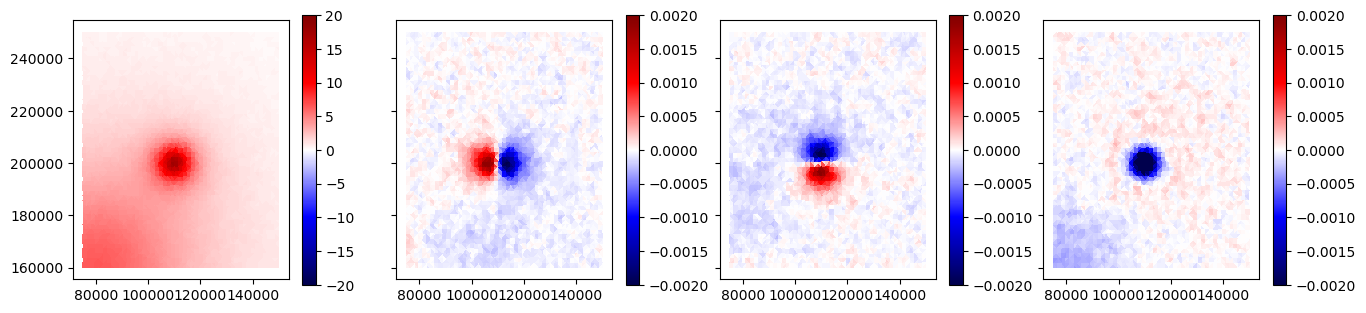

In [64]:
fig, axes = plt.subplots(1, 4, figsize=(16, 3.5), sharey=True)
scale = 0.002
cmap = "seismic"
ax = axes[0]
tmp = ax.tripcolor(x, y, field, cmap=cmap, vmin=-20, vmax=20)
plt.colorbar(tmp)
ax.set_aspect("equal")
for ax, data in zip(axes[1:], [xderiv, yderiv, zderiv]):
    tmp = ax.tripcolor(x, y, data, cmap=cmap, vmin=-scale, vmax=scale)
    ax.set_aspect("equal")
    plt.colorbar(tmp)

## Calculate the matrices involved

In [65]:
def jacobian_parameters(xderiv, yderiv, zderiv, structural_index):
    """
    Calculate the model parameter Jacobian.
    """
    jacobian = np.empty((xderiv.size, 4))
    jacobian[:, 0] = -xderiv
    jacobian[:, 1] = -yderiv
    jacobian[:, 2] = -zderiv
    jacobian[:, 3] = -structural_index
    return jacobian

In [66]:
def jacobian_data(x, y, z, xo, yo, zo, structural_index):
    """
    Calculate the data Jacobian.
    """
    nequations = x.size
    ndata = nequations * 4
    diagonal = np.arange(nequations)
    jacobian = sparse.hstack(
        [
            sparse.diags(np.full(nequations, structural_index)),
            sparse.diags(x - xo),
            sparse.diags(y - yo),
            sparse.diags(z - zo),
        ],
        format="csc",
    )
    return jacobian

In [67]:
def eulers_equation(x, y, z, data, parameters, structural_index):
    """
    Evaluate Euler's equation.
    """
    nequations = x.size
    h, dx, dy, dz = np.split(data, 4)
    xo, yo, zo, baselevel = parameters
    euler = (
        (x - xo) * dx + (y - yo) * dy + (z - zo) * dz + structural_index * (h - baselevel)
    )
    return euler

In [68]:
def gauss_newton_step(parameters, data, coordinates, data_observed, Wd_inv, structural_index):
    """
    Take a step in Gauss-Newton and return new parameters and data.
    """
    x, y, z = coordinates
    h, dx, dy, dz = np.split(data, 4)
    xo, yo, zo, base_level = parameters
    A = jacobian_parameters(dx, dy, dz, structural_index)
    B = jacobian_data(x, y, z, xo, yo, zo, structural_index)
    r = data_observed - data
    f = eulers_equation(x, y, z, data, parameters, structural_index)
    Q = B @ Wd_inv @ B.T
    Q_inv = sparse.linalg.inv(Q)
    ATQ = A.T @ Q_inv
    BTQ = B.T @ Q_inv
    Br = B @ r
    Wd_invBTQ = Wd_inv @ BTQ
    deltap = np.linalg.solve(
        ATQ @ A,
        -ATQ @ (f + Br)
    )
    deltad = r - Wd_invBTQ @ Br - Wd_invBTQ @ (f + A @ deltap)
    return deltap, deltad

In [149]:
def euler_inversion(coordinates, field, xderiv, yderiv, zderiv, structural_index, maxit=50, tol=1e-7):
    """
    """
    data_observed = np.concatenate([field, xderiv, yderiv, zderiv])
    region = vd.get_region(coordinates)
    mean_height = np.mean(coordinates[2])
    parameters = np.array([
        0.5 * (region[1] + region[0]),
        0.5 * (region[3] + region[2]),
        mean_height - np.abs(0.5 * mean_height),
        0,
    ])
    data = 0.8 * np.copy(data_observed)    
    wd = np.concatenate([
        np.full_like(field, 1 / np.linalg.norm(field)),
        np.full_like(field, 1 / np.linalg.norm(xderiv)),
        np.full_like(field, 1 / np.linalg.norm(yderiv)),
        np.full_like(field, 1 / np.linalg.norm(zderiv)),
    ])
    wd = np.ones_like(data)
    Wd_inv = sparse.diags(1 / wd ** 2, format="csc")
    euler = eulers_equation(*coordinates, data, parameters, structural_index)
    euler_misfit = np.sum(np.abs(euler))
    misfit = np.linalg.norm((data_observed - data) * wd)
    merit = misfit**2 + np.sum(np.abs(euler))
    print(f"000 | Euler: {euler_misfit:.3e} | misfit: {misfit:.3e} | merit: {merit:.3e}")    
    for i in range(maxit):
        deltap, deltad = gauss_newton_step(
            parameters,
            data, 
            coordinates, 
            data_observed, 
            Wd_inv, 
            structural_index,
        )
        parameters += deltap
        data += deltad
        euler = eulers_equation(*coordinates, data, parameters, structural_index)
        misfit = np.linalg.norm((data_observed - data) * wd)
        euler_misfit = np.sum(np.abs(euler))
        new_merit = misfit**2 + euler_misfit
        if new_merit > merit:
            print("Increase")
            break
        merit_change = abs((merit - new_merit) / merit)
        merit = new_merit
        print(f"{i + 1:03d} | Euler: {euler_misfit:.3e} | misfit: {misfit:.3e} | merit: {merit:.3e}")
        if merit_change < tol:
            break
    field_pred, dx_pred, dy_pred, dz_pred = np.split(data, 4)
    return parameters, field_pred, dx_pred, dy_pred, dz_pred

In [150]:
def euler_deconvolution(coordinates, field, xderiv, yderiv, zderiv, structural_index):
    x, y, z = coordinates
    A = np.stack([xderiv, yderiv, zderiv, np.full_like(field, structural_index)], axis=1)
    d = x * xderiv + y * yderiv + z * zderiv + structural_index * field
    parameters = np.linalg.solve(A.T @ A, A.T @ d)
    return parameters

In [151]:
structural_index = 2
p_deconv = euler_deconvolution(coordinates, field, xderiv, yderiv, zderiv, structural_index)
p, d, dx, dy, dz = euler_inversion(coordinates, field, xderiv, yderiv, zderiv, structural_index)
print()
print("         True:", " ".join(f"{i[0]:.1f}" for i in center), f"{base_level:.1f}")
print("    Inversion:", " ".join(f"{i:.1f}" for i in p))
print("Devoncolution:", " ".join(f"{i:.1f}" for i in p_deconv))
print()

000 | Euler: 9.622e+03 | misfit: 3.056e+01 | merit: 1.056e+04
001 | Euler: 1.375e+03 | misfit: 7.473e-03 | merit: 1.375e+03
002 | Euler: 1.809e+02 | misfit: 7.104e-03 | merit: 1.809e+02
003 | Euler: 5.854e+00 | misfit: 7.245e-03 | merit: 5.854e+00
004 | Euler: 2.258e-01 | misfit: 7.249e-03 | merit: 2.259e-01
005 | Euler: 8.569e-03 | misfit: 7.249e-03 | merit: 8.622e-03
006 | Euler: 4.001e-04 | misfit: 7.249e-03 | merit: 4.526e-04
007 | Euler: 1.530e-05 | misfit: 7.249e-03 | merit: 6.785e-05
008 | Euler: 7.246e-07 | misfit: 7.249e-03 | merit: 5.328e-05
009 | Euler: 2.748e-08 | misfit: 7.249e-03 | merit: 5.258e-05
010 | Euler: 1.311e-09 | misfit: 7.249e-03 | merit: 5.256e-05
011 | Euler: 4.988e-11 | misfit: 7.249e-03 | merit: 5.255e-05
012 | Euler: 3.185e-12 | misfit: 7.249e-03 | merit: 5.255e-05
Increase

         True: 110000.0 200000.0 -5000.0 0.0
    Inversion: 110444.5 200778.1 -5174.2 1.7
Devoncolution: 109894.8 200835.7 -6158.3 1.6



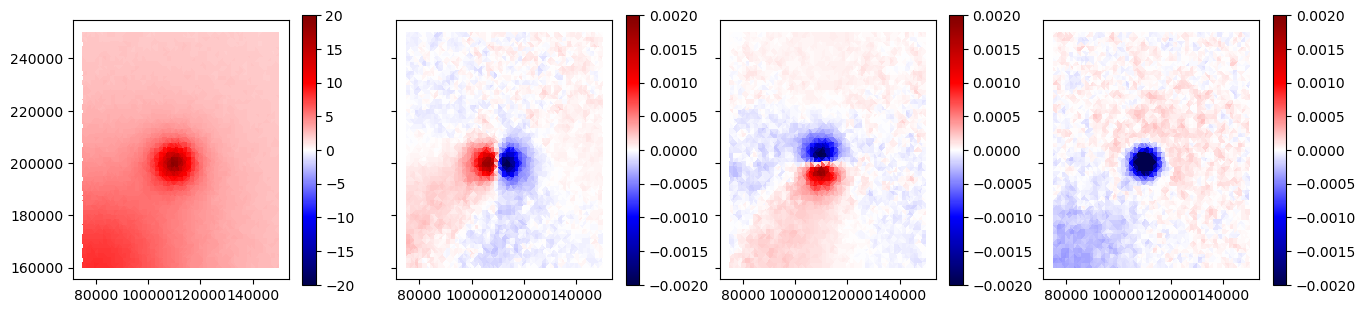

In [152]:
fig, axes = plt.subplots(1, 4, figsize=(16, 3.5), sharey=True)
scale = 0.002
cmap = "seismic"
ax = axes[0]
tmp = ax.tripcolor(x, y, d + p[-1], cmap=cmap, vmin=-20, vmax=20)
plt.colorbar(tmp)
ax.set_aspect("equal")
for ax, data in zip(axes[1:], [dx, dy, dz]):
    tmp = ax.tripcolor(x, y, data, cmap=cmap, vmin=-scale, vmax=scale)
    ax.set_aspect("equal")
    plt.colorbar(tmp)

In [153]:
structural_index = 1
p_deconv = euler_deconvolution(coordinates, field, xderiv, yderiv, zderiv, structural_index)
p, d, dx, dy, dz = euler_inversion(coordinates, field, xderiv, yderiv, zderiv, structural_index)
print()
print("         True:", " ".join(f"{i[0]:.1f}" for i in center), f"{base_level:.1f}")
print("    Inversion:", " ".join(f"{i:.1f}" for i in p))
print("Devoncolution:", " ".join(f"{i:.1f}" for i in p_deconv))
print()

000 | Euler: 6.867e+03 | misfit: 3.056e+01 | merit: 7.801e+03
001 | Euler: 8.789e+02 | misfit: 7.122e-03 | merit: 8.789e+02
002 | Euler: 4.305e+01 | misfit: 7.181e-03 | merit: 4.305e+01
003 | Euler: 5.304e+00 | misfit: 7.310e-03 | merit: 5.304e+00
004 | Euler: 4.015e-02 | misfit: 7.315e-03 | merit: 4.021e-02
005 | Euler: 1.994e-02 | misfit: 7.315e-03 | merit: 1.999e-02
006 | Euler: 2.185e-03 | misfit: 7.315e-03 | merit: 2.238e-03
007 | Euler: 4.513e-04 | misfit: 7.315e-03 | merit: 5.049e-04
008 | Euler: 7.961e-05 | misfit: 7.315e-03 | merit: 1.331e-04
009 | Euler: 1.517e-05 | misfit: 7.315e-03 | merit: 6.869e-05
010 | Euler: 2.821e-06 | misfit: 7.315e-03 | merit: 5.633e-05
011 | Euler: 5.320e-07 | misfit: 7.315e-03 | merit: 5.404e-05
012 | Euler: 9.966e-08 | misfit: 7.315e-03 | merit: 5.361e-05
013 | Euler: 1.874e-08 | misfit: 7.315e-03 | merit: 5.353e-05
014 | Euler: 3.517e-09 | misfit: 7.315e-03 | merit: 5.352e-05
015 | Euler: 6.607e-10 | misfit: 7.315e-03 | merit: 5.351e-05
016 | Eu

In [154]:
structural_index = 3
p_deconv = euler_deconvolution(coordinates, field, xderiv, yderiv, zderiv, structural_index)
p, d, dx, dy, dz = euler_inversion(coordinates, field, xderiv, yderiv, zderiv, structural_index)
print()
print("         True:", " ".join(f"{i[0]:.1f}" for i in center), f"{base_level:.1f}")
print("    Inversion:", " ".join(f"{i:.1f}" for i in p))
print("Devoncolution:", " ".join(f"{i:.1f}" for i in p_deconv))
print()

000 | Euler: 1.341e+04 | misfit: 3.056e+01 | merit: 1.434e+04
001 | Euler: 2.309e+03 | misfit: 1.005e-02 | merit: 2.309e+03
002 | Euler: 4.261e+02 | misfit: 8.392e-03 | merit: 4.261e+02
003 | Euler: 1.665e+01 | misfit: 8.677e-03 | merit: 1.665e+01
004 | Euler: 1.698e+00 | misfit: 8.668e-03 | merit: 1.698e+00
005 | Euler: 1.523e-01 | misfit: 8.668e-03 | merit: 1.524e-01
006 | Euler: 3.411e-02 | misfit: 8.668e-03 | merit: 3.418e-02
007 | Euler: 5.041e-03 | misfit: 8.668e-03 | merit: 5.116e-03
008 | Euler: 8.970e-04 | misfit: 8.668e-03 | merit: 9.722e-04
009 | Euler: 1.456e-04 | misfit: 8.668e-03 | merit: 2.208e-04
010 | Euler: 2.429e-05 | misfit: 8.668e-03 | merit: 9.942e-05
011 | Euler: 3.926e-06 | misfit: 8.668e-03 | merit: 7.905e-05
012 | Euler: 6.389e-07 | misfit: 8.668e-03 | merit: 7.577e-05
013 | Euler: 1.025e-07 | misfit: 8.668e-03 | merit: 7.523e-05
014 | Euler: 1.649e-08 | misfit: 8.668e-03 | merit: 7.514e-05
015 | Euler: 2.635e-09 | misfit: 8.668e-03 | merit: 7.513e-05
016 | Eu